In [778]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt

#Declare constants
center_wave=1550e-9

#Simulation parameters
propagationLoss = 1.5 #loss in dB/cm
length_between = 200e-6 

n_eff0 = 2.35
n_eff1 = 2.35
n_eff2 = 2.47

#width in um
width0 = 0.45
width1 = 0.45
width2 = 0.55

#number of gratings 
N = 60
#length of each grating segment
l = 160e-9 #use this line to manually set length otherwise length will be calculated 
# l = center_wave / 2 / ((n_eff1 + n_eff2) / 2) / 2 
print(l)
#total length of grating is N * l
print(f"Total Grating length {2 * N * l * 10e6:.3f} micron")

#set to 0 for no apodization
apodization = 0.04

1.6e-07
Total Grating length 192.000 micron


In [715]:
def apodize(N, N_i, delta_n):
    #choose which apodization profile to use
    #sinc
    # return delta_n * (np.sinc(N_i/N * 2 * np.pi - np.pi))

    #raised sin
    # return delta_n * (np.sin(N_i/N * np.pi)) ** 2
    
    #blackman
    return delta_n * (1 + 1.19 * np.cos(N_i/ N * 2 * np.pi - np.pi) + 0.19 * np.cos(2*(N_i/ N * 2 * np.pi - np.pi))) / 2.38
    
    #tanh 
    # if N_i < N/2:
    #     return delta_n * np.tanh(8 * N_i/N) 
    # else:
    #     return delta_n * np.tanh(8*(N - N_i)/N)

In [728]:
def n_eff_lambda(wl):
    wl = wl * 1e3
    return 2.4379 - 1.1193 * (wl - center_wave) - 0.035 * (wl - center_wave) ** 2

In [736]:
def delta_n_eff_width(w):
    #this model only works for w around 500 nm
    return 1.6412 * (w - 0.5) - 5.2487 * (w - 0.5) ** 2 + 10.4285 * (w - 0.5) ** 3

In [719]:
#Transfer Matrix Method
def calculate_reflection_transmission(wavelength, n_eff0, n_eff1, n_eff2, N, l, propagationLoss):
    alpha = (propagationLoss * 1e2) / 4.34
    r_12 = (n_eff1 - n_eff2)/(n_eff1+n_eff2)
    r_21 = (n_eff2 - n_eff1)/(n_eff1+n_eff2)
    t_12 = (2 * n_eff1)/(n_eff1+n_eff2)
    t_21 = (2 * n_eff2)/(n_eff1+n_eff2)

    T20 = np.array([[(n_eff2 + n_eff0)/(2 * n_eff2), (n_eff2 - n_eff0)/(2 * n_eff2)],
                    [(n_eff2 - n_eff0)/(2 * n_eff2), (n_eff2 + n_eff0)/(2 * n_eff2)]])
    T01 = np.array([[(n_eff0 + n_eff1)/(2 * n_eff0), (n_eff0 - n_eff1)/(2 * n_eff0)],
                    [(n_eff0 - n_eff1)/(2 * n_eff0), (n_eff0 + n_eff1)/(2 * n_eff0)]])

    T12 = np.array([[1/t_12, r_12/t_12],
                    [r_12/t_12, 1/t_12]])
    T21 = np.array([[1/t_21, r_21/t_21],
                    [r_21/t_21, 1/t_21]])

    beta1 = (2 * np.pi * n_eff1)/wavelength - (alpha/2)*1j
    beta2 = (2 * np.pi * n_eff2)/wavelength - (alpha/2)*1j

    #populate propagation matrices
    P1 = np.array([[np.exp(beta1 * l * 1j), 0],
                   [0, np.exp(beta1 * l * -1j)]
                   ])
    P2 = np.array([[np.exp(beta2 * l * 1j), 0],
                   [0, np.exp(beta2 * l * -1j)]
                   ])
    P1_phase_shift = np.array([[np.exp(beta1 * length_between * 1j), 0],
                                [0, np.exp(beta1 * length_between * -1j)]])

    #Multiply Matrices Together
    M = T01
    for i in range(N):
        if apodization != 0:
            delta_n = apodize(N=N, N_i=i + 1, delta_n=apodization)
            n_eff2new = n_eff2 + delta_n
            n_eff1new = n_eff1 - delta_n
            r_12 = (n_eff1new - n_eff2new)/(n_eff1new + n_eff2new)
            r_21 = (n_eff2new - n_eff1new)/(n_eff1new + n_eff2new)
            t_12 = (2 * n_eff1new)/(n_eff1new + n_eff2new)
            t_21 = (2 * n_eff2new)/(n_eff1new + n_eff2new)
            
            T12 = np.array([[1/t_12, r_12/t_12],
                            [r_12/t_12, 1/t_12]])
            T21 = np.array([[1/t_21, r_21/t_21],
                            [r_21/t_21, 1/t_21]])
            
            # T20 = np.array([[(n_eff2new + n_eff0)/(2 * n_eff2new), (n_eff2new - n_eff0)/(2 * n_eff2new)],
            #         [(n_eff2new - n_eff0)/(2 * n_eff2new), (n_eff2new + n_eff0)/(2 * n_eff2new)]])
            # T01 = np.array([[(n_eff0 + n_eff1)/(2 * n_eff0), (n_eff0 - n_eff1)/(2 * n_eff0)],
            #         [(n_eff0 - n_eff1)/(2 * n_eff0), (n_eff0 + n_eff1)/(2 * n_eff0)]])
    
            beta1 = (2 * np.pi * n_eff1new)/wavelength - (alpha/2)*1j
            beta2 = (2 * np.pi * n_eff2new)/wavelength - (alpha/2)*1j
    
            #populate propagation matrices
            P1 = np.array([[np.exp(beta1 * l * 1j), 0],
                           [0, np.exp(beta1 * l * -1j)]
                           ])
            P2 = np.array([[np.exp(beta2 * l * 1j), 0],
                           [0, np.exp(beta2 * l * -1j)]
                           ])
            
            
        if i == N - 1:
            M = M @ P1 @ T12 @ P2 @ T20
        # elif i == int((N / 2)):
        #     M = M @ P1_phase_shift 
        else:
            M = M @ P1 @ T12 @ P2 @ T21
            
    #Calculate reflectance and transmittance 
    R = abs((M[1,0]/M[0,0]))**2
    T = abs(1/M[0,0])**2
    return R, T

In [769]:
def calculate_reflection_transmission_width(wavelength, width0, width1, width2, N, l, propogationLoss):
    alpha = (propogationLoss * 1e2) / 4.34
    n_eff0 = n_eff_lambda(wavelength) + delta_n_eff_width(width0)
    n_eff1 = n_eff_lambda(wavelength) + delta_n_eff_width(width1)
    n_eff2 = n_eff_lambda(wavelength) + delta_n_eff_width(width2)
    
    r_12 = (n_eff1 - n_eff2)/(n_eff1+n_eff2)
    r_21 = (n_eff2 - n_eff1)/(n_eff1+n_eff2)
    t_12 = (2 * n_eff1)/(n_eff1+n_eff2)
    t_21 = (2 * n_eff2)/(n_eff1+n_eff2)

    T20 = np.array([[(n_eff2 + n_eff0)/(2 * n_eff2), (n_eff2 - n_eff0)/(2 * n_eff2)],
                    [(n_eff2 - n_eff0)/(2 * n_eff2), (n_eff2 + n_eff0)/(2 * n_eff2)]])
    T01 = np.array([[(n_eff0 + n_eff1)/(2 * n_eff0), (n_eff0 - n_eff1)/(2 * n_eff0)],
                    [(n_eff0 - n_eff1)/(2 * n_eff0), (n_eff0 + n_eff1)/(2 * n_eff0)]])

    T12 = np.array([[1/t_12, r_12/t_12],
                    [r_12/t_12, 1/t_12]])
    T21 = np.array([[1/t_21, r_21/t_21],
                    [r_21/t_21, 1/t_21]])

    beta1 = (2 * np.pi * n_eff1)/wavelength - (alpha/2)*1j
    beta2 = (2 * np.pi * n_eff2)/wavelength - (alpha/2)*1j

    #populate propagation matrices
    P1 = np.array([[np.exp(beta1 * l * 1j), 0],
                   [0, np.exp(beta1 * l * -1j)]
                   ])
    P2 = np.array([[np.exp(beta2 * l * 1j), 0],
                   [0, np.exp(beta2 * l * -1j)]
                   ])
    P1_phase_shift = np.array([[np.exp(beta1 * length_between * 1j), 0],
                                [0, np.exp(beta1 * length_between * -1j)]])
    
    
    M = T01
    for i in range(N):
        if i == N - 1:
            M = M @ P1 @ T12 @ P2 @ T20
        # elif i == int((N / 2)):
        #     M = M @ P1_phase_shift 
        else:
            M = M @ P1 @ T12 @ P2 @ T21
            
    #Calculate reflectance and transmittance 
    R = abs((M[1,0]/M[0,0]))**2
    T = abs(1/M[0,0])**2
    return R, T

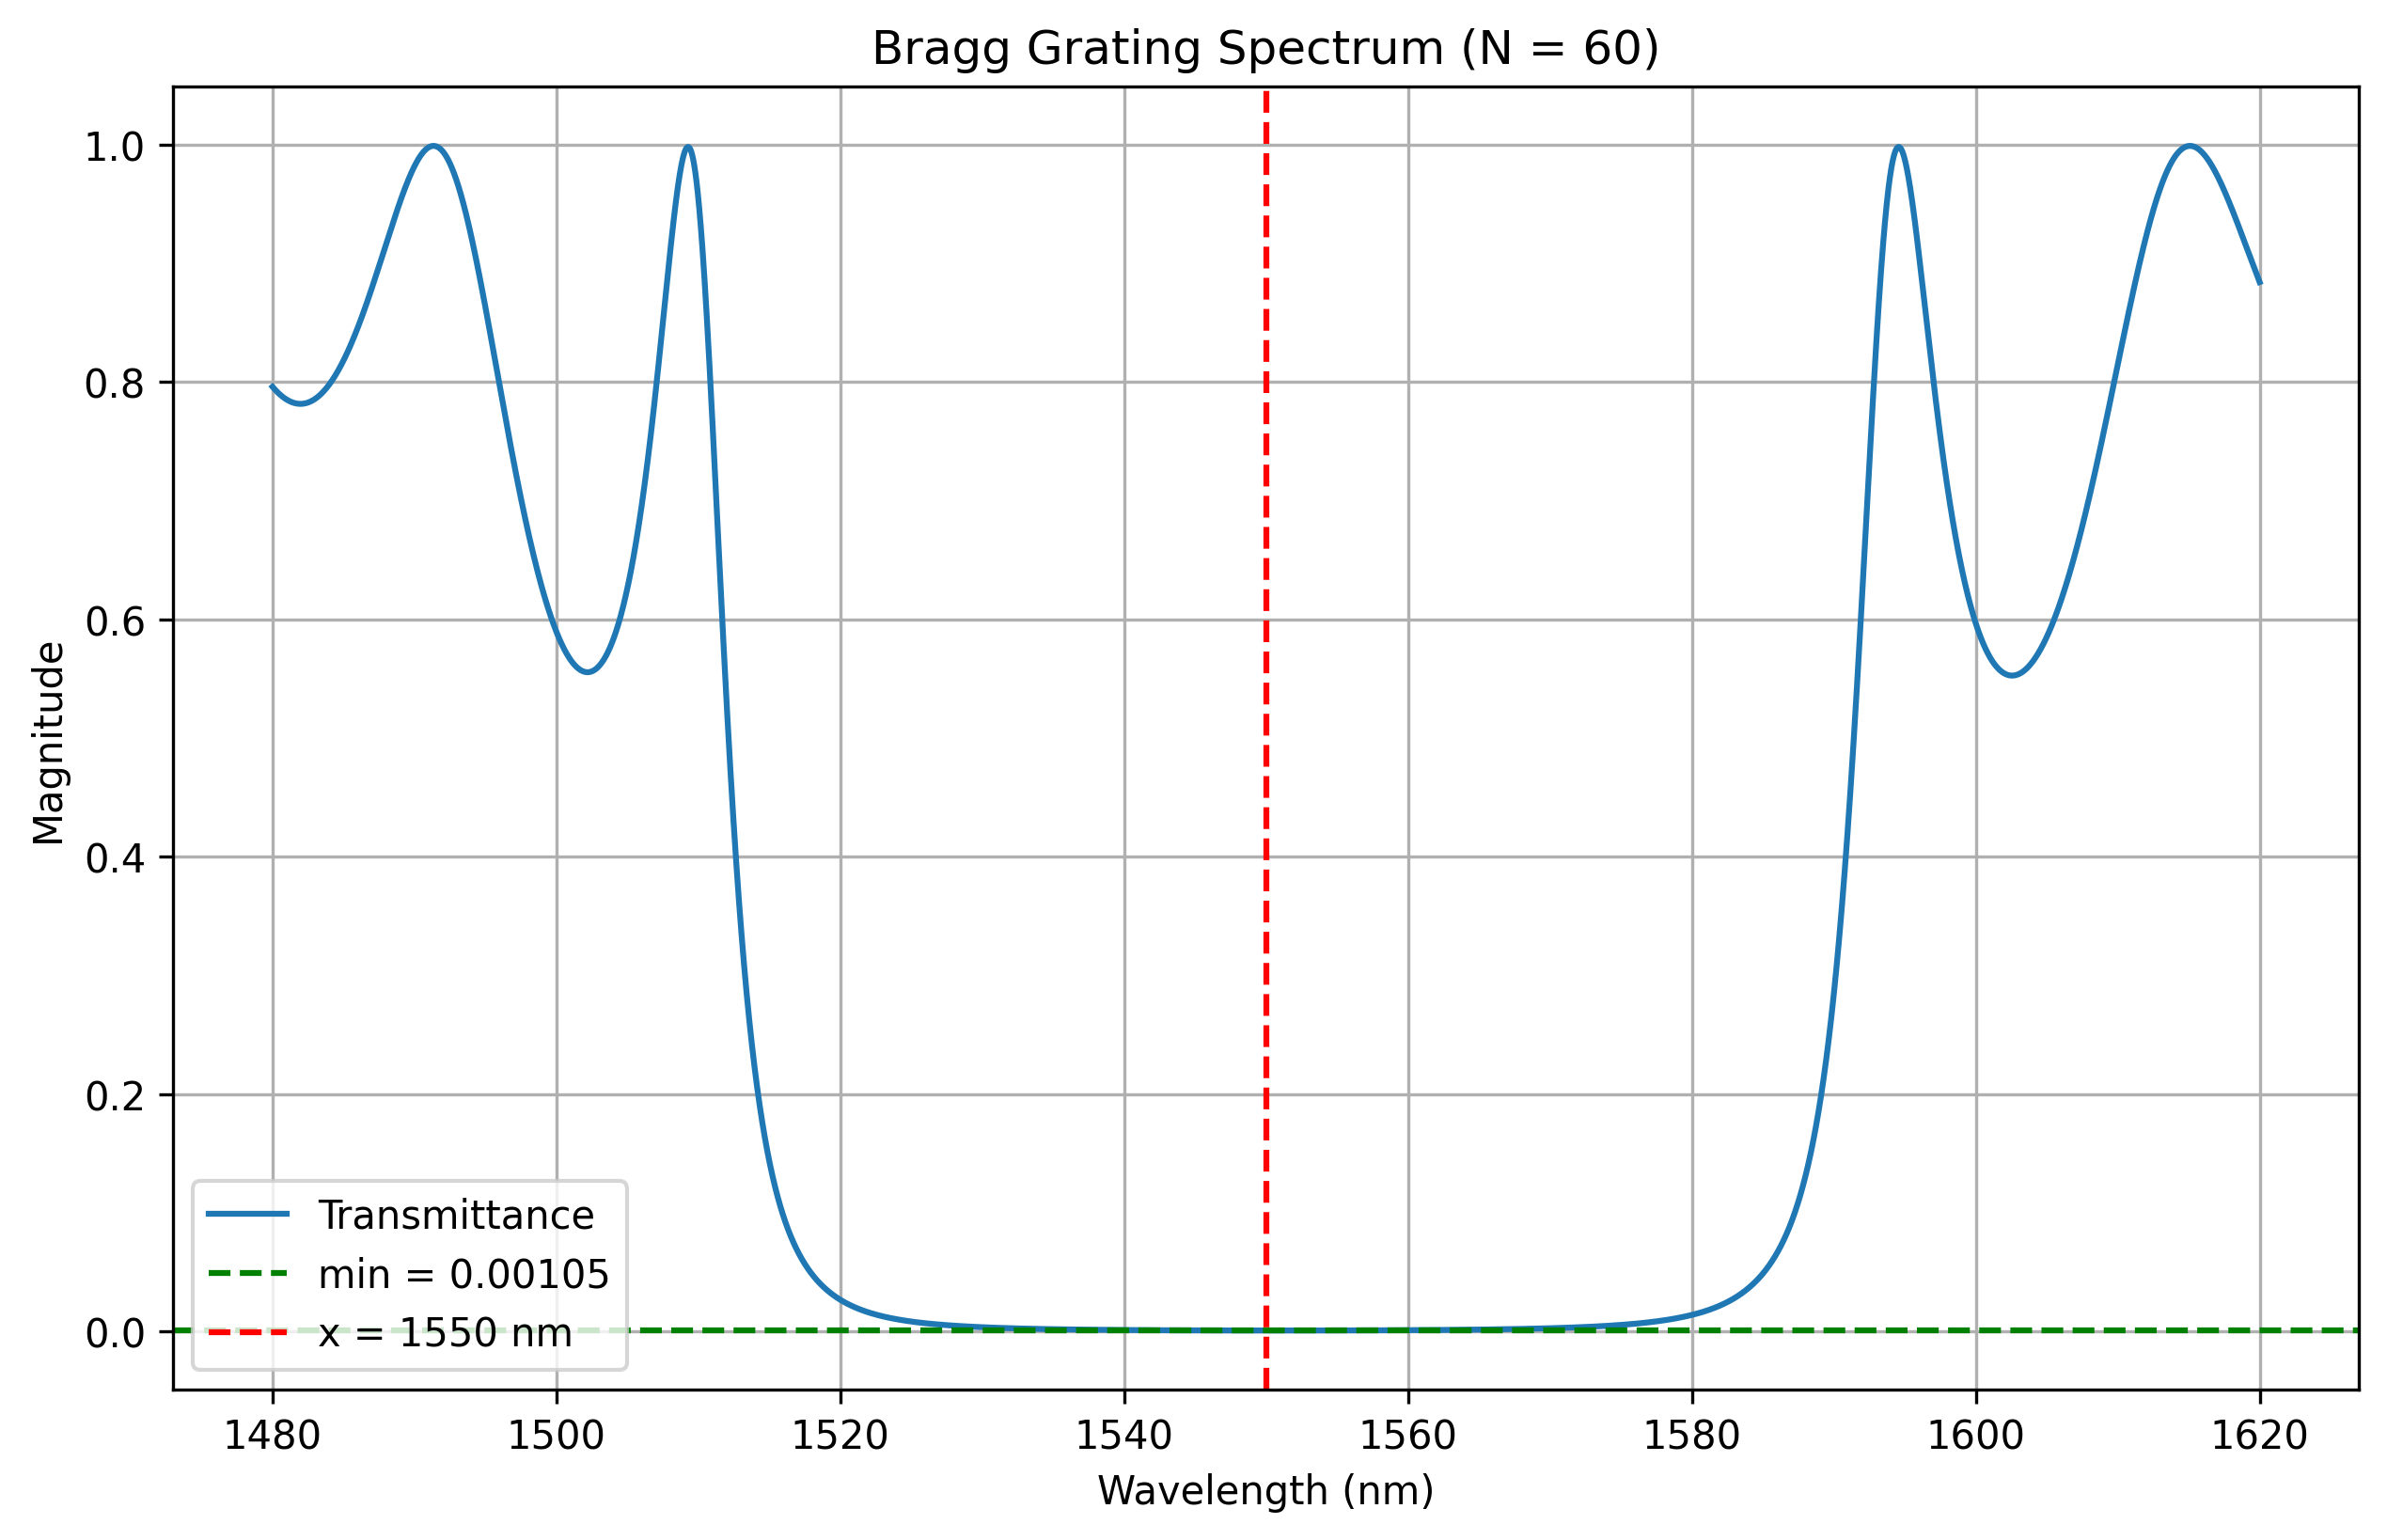

In [779]:
"""Run this cell to graph spectrum"""

# Define the wavelength spectrum
wavelengths = np.linspace(1480e-9,1620e-9,10000)

# Calculate Reflectance and Transmittance over the spectrum
R_list = []
T_list = []

for wl in wavelengths:
    #choose if you want to calculate based off width of just index
    # R, T = calculate_reflection_transmission(wl, n_eff0, n_eff1, n_eff2, N, l, propagationLoss)
    R, T = calculate_reflection_transmission_width(wl, width0, width1, width2, N, l,propagationLoss)
    R_list.append(R)
    T_list.append(T)

# Plot the results
plt.figure(figsize=(10, 6), dpi = 300)
# plt.plot(wavelengths * 1e9, R_list, label='Reflectance')
plt.plot(wavelengths * 1e9, T_list, label='Transmittance')
# plt.plot(wavelengths * 1e9, total, label='Total')
min = np.min(T_list)
plt.axhline(y = min, color = 'g', linestyle = '--', label = f'min = {min:.5f}')
plt.axvline(x=1550, color='r', linestyle='--', label='x = 1550 nm')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Magnitude')
plt.title(f'Bragg Grating Spectrum (N = {N})')

# def apodize(N, N_i, delta_n):
#     return delta_n * (np.sin(N_i/N * np.pi)) ** 2
# 
# R_list = []
# T_list = []
# 
# for wl in wavelengths:
#     R, T = calculate_reflection_transmission(wl, n_eff0, n_eff1, n_eff2, N, l, propagationLoss)
#     R_list.append(R)
#     T_list.append(T)
# 
# # plt.plot(wavelengths * 1e9, R_list, label='Reflectance')
# plt.plot(wavelengths * 1e9, T_list, label='Sin')
# 
# n_eff0 = 2.35
# n_eff1 = 2.35
# n_eff2 = 2.5
# R_list = []
# T_list = []
# apodization = 0
# for wl in wavelengths:
#     R, T = calculate_reflection_transmission(wl, n_eff0, n_eff1, n_eff2, N, l, propagationLoss)
#     R_list.append(R)
#     T_list.append(T)
# 
# plt.plot(wavelengths * 1e9, T_list, label='Unapodized Transmittance')

plt.legend()
plt.grid(True)
plt.show()

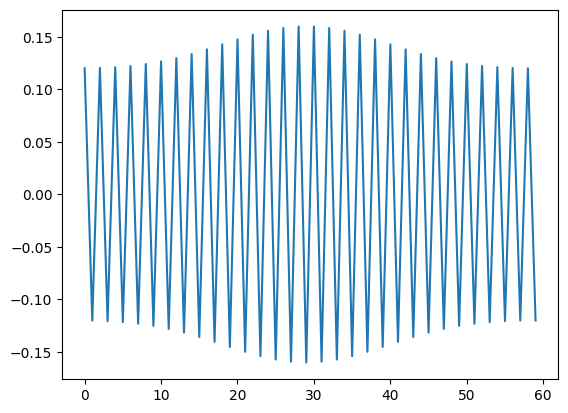

In [709]:
"""This cell is used to graph the index profile from apodization"""

# apodization = 0.04
# delta = []
# I = []
# for i in range(N):
#     delta_n = apodize(N=N, N_i=i + 1, delta_n=apodization)
#     n_eff2new = n_eff2 #+ delta_n
#     n_eff1new = n_eff1 - delta_n
#     if i % 2 == 0:
#         delta.append(n_eff2new - n_eff1new)
#     else:
#         delta.append(n_eff1new - n_eff2new)
#     I.append(i)
# plt.plot(I, delta, color = 'purple')

n_eff0 = 2.35
n_eff1 = 2.35
n_eff2 = 2.47
R_list = []
T_list = []
apodization = 0.04

delta = []
I = []
for i in range(N):
    delta_n = apodize(N=N, N_i=i + 1, delta_n=apodization)
    n_eff2new = n_eff2 + delta_n
    n_eff1new = n_eff1 #- delta_n
    if i % 2 == 0:
        delta.append(n_eff2new - n_eff1new)
    else:
        delta.append(n_eff1new - n_eff2new)
    I.append(i)
plt.plot(I, delta)

In [ ]:
"""This cell is used to turn the index profile to a width profile"""
def index_to_width(wl, n):
    delta = n - n_eff_lambda(wl)

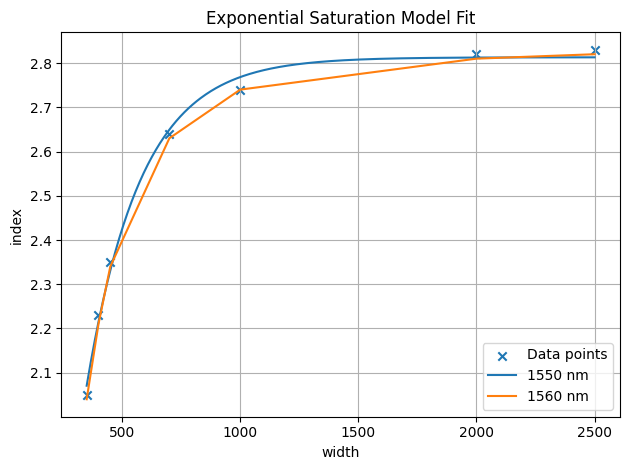


Fitted parameters:
  y_inf (asymptote) = 2.8131
  a                 = 3.3707
  k                 = 0.004323
Coefficient of determination (R²) = 0.9961


In [713]:
"""This cell is used to plot the index vs width and provide a line of best fit"""

# -----------------------------------------------------------
# 1.  Data
# -----------------------------------------------------------
width = np.array([350, 400, 450, 700, 1000, 2000, 2500], dtype=float)
wavelength_1550 = np.array([2.05, 2.23, 2.35, 2.64, 2.74, 2.82, 2.83], dtype=float)
wavelength_1560 = np.array([2.04, 2.21, 2.34, 2.63, 2.74, 2.81, 2.82], dtype=float)
wavelength_1570 = np.array([])

# -----------------------------------------------------------
# 2.  Model: y = y_inf − a·exp(−k·x)
# -----------------------------------------------------------
def exp_saturation(x, y_inf, a, k):
    return y_inf - a * np.exp(-k * x)

# -----------------------------------------------------------
# 3.  Parameter estimation
#     • If SciPy is available we use curve_fit
#     • Otherwise we fall back to a simple brute-force search
# -----------------------------------------------------------
try:
    from scipy.optimize import curve_fit

    popt, _ = curve_fit(
        exp_saturation,
        x,
        y,
        p0=[3.0, 1.0, 0.001],  # initial guesses
        maxfev=10_000,
    )
    y_inf, a, k = popt
except ModuleNotFoundError:
    # Brute-force grid over y_inf, then linear regression on ln(y_inf − y)
    y_inf_candidates = np.linspace(y.max() + 0.01, y.max() + 0.5, 200)
    best_ss_res = np.inf
    y_inf = a = k = None

    for y_inf_try in y_inf_candidates:
        diffs = y_inf_try - y
        if np.any(diffs <= 0):
            continue  # skip invalid candidate

        ln_terms = np.log(diffs)
        A = np.vstack([np.ones_like(x), -x]).T
        # Solve ln(y_inf − y) = ln(a) − k·x
        beta, *_ = np.linalg.lstsq(A, ln_terms, rcond=None)
        ln_a, k_est = beta
        a_est = np.exp(ln_a)

        residuals = y - exp_saturation(x, y_inf_try, a_est, k_est)
        ss_res = np.sum(residuals**2)

        if ss_res < best_ss_res:
            best_ss_res = ss_res
            y_inf, a, k = y_inf_try, a_est, k_est

# -----------------------------------------------------------
# 4.  Goodness of fit (R²)
# -----------------------------------------------------------
residuals = y - exp_saturation(x, y_inf, a, k)
ss_res = np.sum(residuals ** 2)
ss_tot = np.sum((y - y.mean()) ** 2)
r2 = 1 - ss_res / ss_tot

# -----------------------------------------------------------
# 5.  Plot
# -----------------------------------------------------------
x_fit = np.linspace(width.min(), width.max(), 500)
y_fit = exp_saturation(x_fit, y_inf, a, k)

plt.scatter(width, wavelength_1550, marker="x", label="Data points")
plt.plot(x_fit, y_fit, label="1550 nm")
plt.plot(width, wavelength_1560, label="1560 nm")
plt.xlabel("width")
plt.ylabel("index")
plt.title("Exponential Saturation Model Fit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------------------------------------
# 6.  Output parameters
# -----------------------------------------------------------
print("\nFitted parameters:")
print(f"  y_inf (asymptote) = {y_inf:.4f}")
print(f"  a                 = {a:.4f}")
print(f"  k                 = {k:.6f}")
print(f"Coefficient of determination (R²) = {r2:.4f}")